**Notebook** : clean_stationSob_data.ipynb

**Auteur(s)** : Mame Diarra DIOUF, Cheikhou Akhmed KANE, Anna NDIAYE

**Description** : Nettoyage des données meteo brutes de la station de Sob

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [65]:
# Définir les chemins
base_dir = Path.cwd().parent.resolve()
input_path = base_dir / "data" / "climat" / "stationSob" / "donnees_station_SOB.xlsx"
output_path = base_dir / "data" / "climat" / "processed" / "stationSob_journalier_maelia.csv"

In [66]:
# ---------------- CONSTANTES ---------------- #
gamma = 0.0665  # kPa/°C
Cn = 900        # coefficient FAO-56 pour référence herbacée
Cd = 0.34

# ---------------- FONCTIONS ---------------- #
def saturation_vapor_pressure(T):
    return 0.6108 * np.exp((17.27 * T) / (T + 237.3))  # kPa

def delta_svp(T):
    e_s = saturation_vapor_pressure(T)
    return (4098 * e_s) / ((T + 237.3) ** 2)

def etp_penman_monteith_fao56(row):
    T = row["Tmean"]
    RH = row["RHmean"]
    u2 = row["Wind_Speed_mean"]
    Rn = row["RGI"]  # MJ/m²/jour

    e_s = saturation_vapor_pressure(T)
    e_a = e_s * RH / 100
    delta = delta_svp(T)

    num = 0.408 * delta * Rn + gamma * (Cn / (T + 273)) * u2 * (e_s - e_a)
    den = delta + gamma * (1 + Cd * u2)

    return max(0, num / den)

In [67]:
# Charger le fichier en sautant les 9 premières lignes et la premiere colonne, utiliser la 10e comme header
df = pd.read_excel(input_path, header=9)
df.drop(df.columns[0], axis=1, inplace=True)

In [68]:
# ---------------- PRÉTRAITEMENT ---------------- #
df["TIME_START"] = pd.to_datetime(df["TIME_START"], format="%Y%m%d%H%M")
df["DATE"] = df["TIME_START"].dt.strftime("%d/%m/%Y")
df["Precipitation"] = df["Precipitation"] / 2
df["RGI_30min"] = df["Net_radiation_1"] * 1.8 / 1000  # MJ/m² sur 30 minutes

In [69]:
# ---------------- AGRÉGATION JOURNALIÈRE ---------------- #
df_daily = df.groupby("DATE").agg({
    "Precipitation": "sum",
    "Air_Temperature_at_2_m": ["min", "max", "mean"],
    "Relative_Humidity": "mean",
    "Wind_Speed": "mean",
    "RGI_30min": "sum"
}).reset_index()

# Aplatir les colonnes
df_daily.columns = ["DATE", "RRmm", "Tmin", "Tmax", "Tmean", "RHmean", "Wind_Speed_mean", "RGI"]

In [70]:
df_daily.tail()

,DATE,RRmm,Tmin,Tmax,Tmean,RHmean,Wind_Speed_mean,RGI
2552,31/12/2020,0.0,20.11,39.65,28.027708,42.416458,3.558729,5.347924
2553,31/12/2021,0.0,14.47,37.31,25.344167,20.412292,3.251479,3.765244
2554,31/12/2022,0.0,16.52,35.18,24.772500,34.801042,3.406125,6.294911
2555,31/12/2023,0.0,15.48,38.75,26.191667,19.253542,2.746104,5.547451
2556,31/12/2024,0.0,19.41,37.29,27.325417,26.994792,3.427292,6.988068


In [71]:
# ---------------- CALCUL ETP ---------------- #
df_daily["ETP"] = df_daily.apply(etp_penman_monteith_fao56, axis=1)

# ---------------- FORMAT FINAL ---------------- #
df_maelia = df_daily[["DATE", "RRmm", "Tmin", "Tmax", "ETP", "RGI"]]
df_maelia["DATE"] = pd.to_datetime(df_maelia["DATE"], format="%d/%m/%Y") 

df_maelia.tail()

C:\Users\Cheikhou\AppData\Local\Temp\ipykernel_20072\3550748391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maelia["DATE"] = pd.to_datetime(df_maelia["DATE"], format="%d/%m/%Y")


,DATE,RRmm,Tmin,Tmax,ETP,RGI
2552,2020-12-31,0.0,20.11,39.65,5.508105,5.347924
2553,2021-12-31,0.0,14.47,37.31,5.942771,3.765244
2554,2022-12-31,0.0,16.52,35.18,5.678613,6.294911
2555,2023-12-31,0.0,15.48,38.75,5.959369,5.547451
2556,2024-12-31,0.0,19.41,37.29,6.780620,6.988068


In [79]:
print(df_maelia["DATE"].duplicated().sum()) #doit etre egal a zero 0

0


✅ Figure sauvegardée : C:\Users\Cheikhou\Desktop\Ferlo_Sine\maelia-instanciation-ferlo-sine\figures\rrmm_journalier_stationSob.png


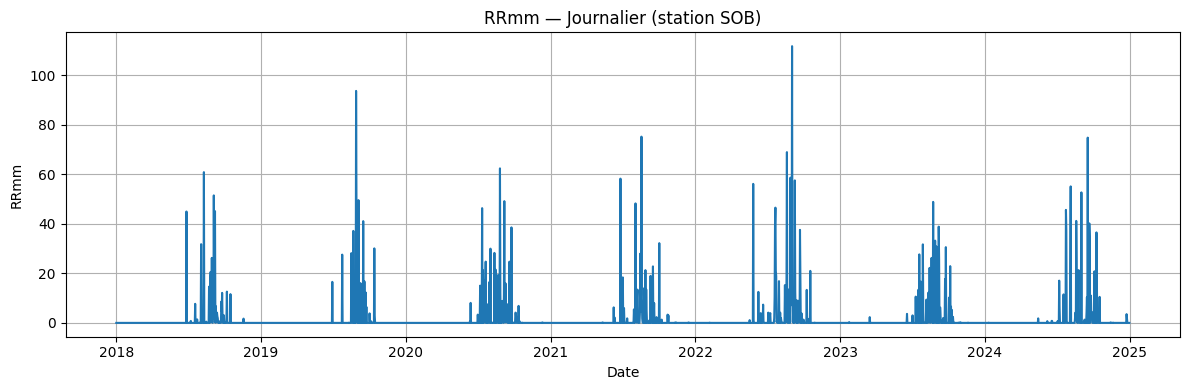

✅ Figure sauvegardée : C:\Users\Cheikhou\Desktop\Ferlo_Sine\maelia-instanciation-ferlo-sine\figures\tmin_journalier_stationSob.png


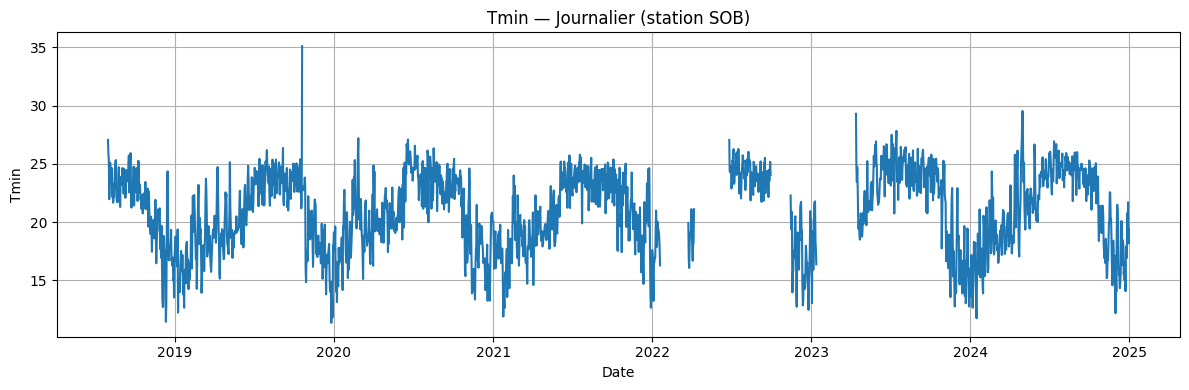

✅ Figure sauvegardée : C:\Users\Cheikhou\Desktop\Ferlo_Sine\maelia-instanciation-ferlo-sine\figures\tmax_journalier_stationSob.png


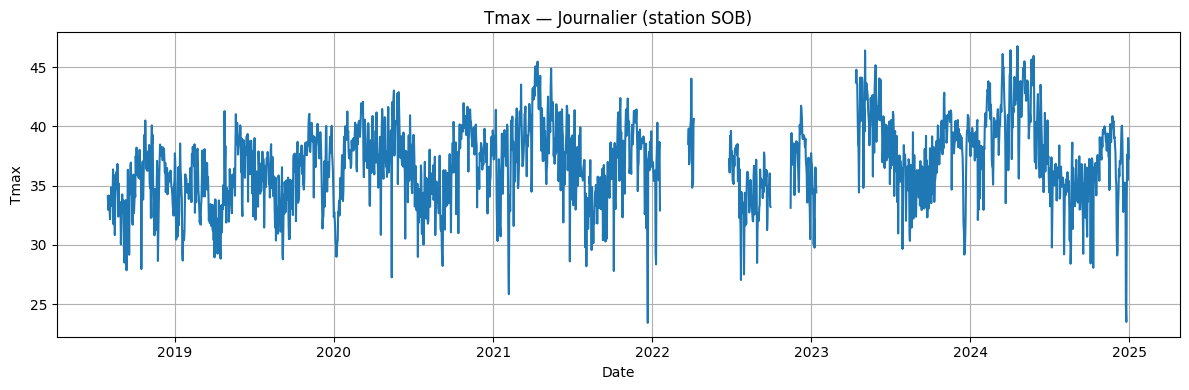

✅ Figure sauvegardée : C:\Users\Cheikhou\Desktop\Ferlo_Sine\maelia-instanciation-ferlo-sine\figures\etp_journalier_stationSob.png


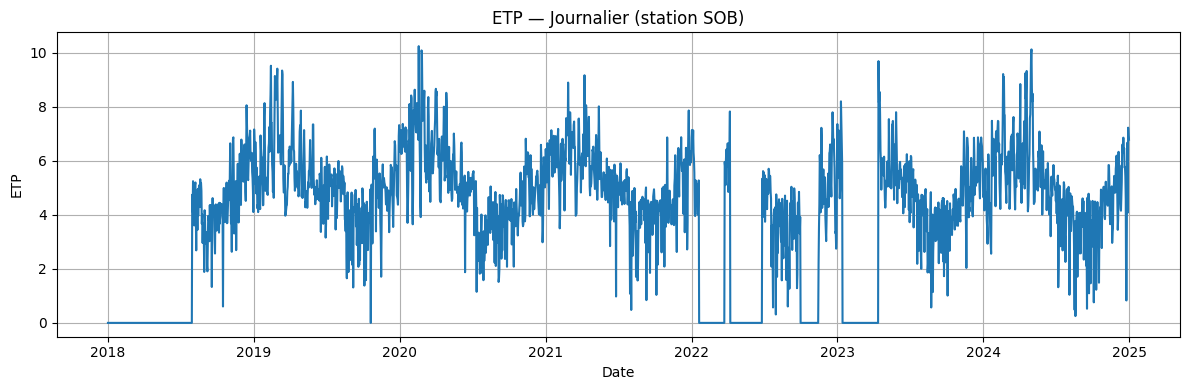

✅ Figure sauvegardée : C:\Users\Cheikhou\Desktop\Ferlo_Sine\maelia-instanciation-ferlo-sine\figures\rgi_journalier_stationSob.png


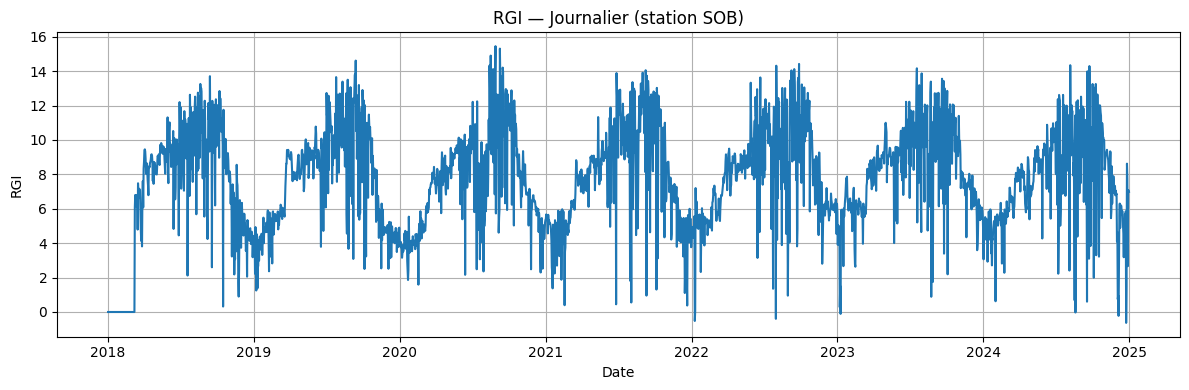

In [82]:
# Assurer le tri
df_maelia = df_maelia.sort_values("DATE")

# Liste des variables à tracer
variables = ["RRmm", "Tmin", "Tmax", "ETP", "RGI"]

# Dossier de sauvegarde
figures_dir = base_dir / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

# Tracer et sauvegarder chaque variable
for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(df_maelia["DATE"], df_maelia[var], color="tab:blue")
    plt.title(f"{var} — Journalier (station SOB)")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.grid(True)
    plt.tight_layout()

    # Sauvegarder d’abord
    fig_path = figures_dir / f"{var.lower()}_journalier_stationSob.png"
    plt.savefig(fig_path)
    print(f"✅ Figure sauvegardée : {fig_path}")

    # Ensuite afficher
    plt.show()


In [83]:
# ---------------- EXPORT ---------------- #
df_maelia["DATE"] = df_maelia["DATE"].dt.strftime("%d/%m/%Y")  # pour compatibilité MAELIA
output_path.parent.mkdir(parents=True, exist_ok=True)
df_maelia.to_csv(output_path, sep=";", index=False)
print(f"✅ Données enregistrées dans : {output_path}")

✅ Données enregistrées dans : C:\Users\Cheikhou\Desktop\Ferlo_Sine\maelia-instanciation-ferlo-sine\data\climat\processed\stationSob_journalier_maelia.csv
